# Diagnosis of possible issues with EE model

From [this benchmark](https://gaow.github.io/mvarbvs/analysis/20191116_MNM_Benchmark.html) I see some runs with EE model has inflated FDR with no missing data. Here are some digging into it.

In [1]:
%cd ~/GIT/mvarbvs/dsc_mnm

/project2/mstephens/gaow/mvarbvs/dsc_mnm

Here I load previous benchmark results and identify some scenarios where there is a problem,

In [2]:
out = readRDS('../data/finemap_output.20191116.rds')

In [3]:
res = out[,-1]
colnames(res) = c('n_traits', 'resid_method', 'missing', 'EZ_model', 'L', 'total', 'valid', 'size', 'purity', 'top_hit', 'total_true', 'total_true_included', 'overlap_var', 'overlap_cs', 'false_positive_cross_cond', 'false_negative_cross_cond', 'true_positive_cross_cond', 'elbo_converged', 'filename')

In [27]:
bad = res[which(res$total-res$valid>0),]

In [28]:
bad = bad[which(bad$missing==FALSE & bad$EZ_model==0 & bad$n_traits==45 & bad$L<10),]
nrow(bad)

[1] 412

There are quite a few of them with 45 traits. But none seen for $R=5$ or $R=10$. Changing `EZ_model == 1` there is only one such instance as opposed to 412 here.

In [29]:
head(bad)

,n_traits,resid_method,missing,EZ_model,L,total,valid,size,purity,top_hit,total_true,total_true_included,overlap_var,overlap_cs,false_positive_cross_cond,false_negative_cross_cond,true_positive_cross_cond,elbo_converged,filename
6521,45,oracle,FALSE,0,1,1,0,17.0,0.9975257,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_21_high_het_2_oracle_generator_1_mnm_high_het_7_susie_scores_1
6913,45,oracle,FALSE,0,1,1,0,37.0,1.0000000,0,1,0,0,0,45,0,0,TRUE,susie_scores/full_data_413_high_het_2_oracle_generator_1_mnm_high_het_7_susie_scores_1
8508,45,oracle,FALSE,0,2,2,1,2.5,0.9960307,1,1,1,0,0,11,34,45,TRUE,susie_scores/full_data_8_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8510,45,oracle,FALSE,0,2,2,1,1.5,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_10_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8511,45,oracle,FALSE,0,2,2,1,24.0,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_11_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1
8512,45,oracle,FALSE,0,2,2,1,2.0,1.0000000,0,1,1,0,0,0,45,45,TRUE,susie_scores/full_data_12_high_het_2_oracle_generator_1_mnm_high_het_9_susie_scores_1


Load the 3rd line of dataset identified -- that is, two CS identified but only one of them is valid:

In [30]:
ex = readRDS('mnm_20191116/mnm_high_het/full_data_8_high_het_2_oracle_generator_1_mnm_high_het_9.rds')

In [33]:
DSC_19D98699 <- dscrutils::load_inputs(c('mnm_20191116/oracle_generator/oracle_generator_1.pkl','mnm_20191116/full_data/full_data_8.rds','mnm_20191116/high_het/full_data_8_high_het_2.pkl'), dscrutils::read_dsc)
meta <- DSC_19D98699$meta

The original result from DSC is presented in a plot of PIP and CS, where true signal is in red:

In [4]:
true_pos = as.integer(apply(meta$true_coef, 1, sum) != 0)

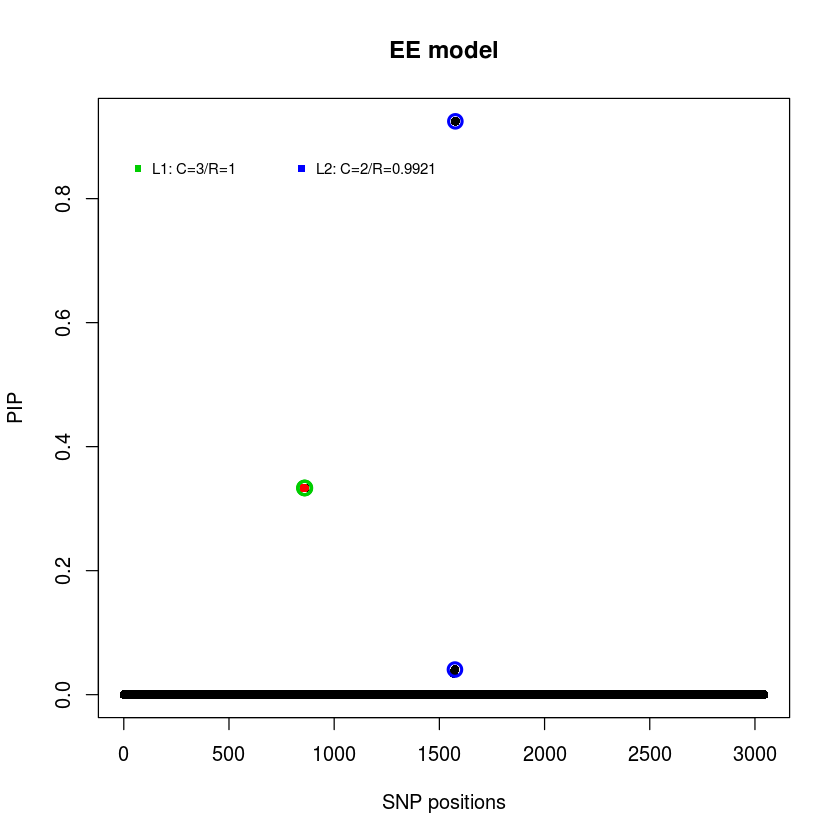

In [36]:
susieR::susie_plot(ex$result,y='PIP', main = 'EE model', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Reproducing the problem with diagnostic information

Starting with analyzing with `L=1`:

In [37]:
DSC_REPLICATE <- DSC_19D98699$DSC_DEBUG$replicate
X <- DSC_19D98699$X
Y <- DSC_19D98699$Y
cfg <- DSC_19D98699$configurations
prior = cfg[[as.character(ncol(Y))]][['high_het']]

In [2]:
compute_cov_diag <- function(Y){
    covar <- diag(apply(Y, 2, var, na.rm=T))
    return(covar)
}

In [1]:
#saveRDS(list(X=X,Y=Y,meta=meta,prior=prior,DSC_REPLICATE=DSC_REPLICATE), 'issue_9_EE.rds')
attach(readRDS('/home/gaow/tmp/05-Dec-2019/issue_9_EE.rds'))

In [3]:
resid_Y <- compute_cov_diag(Y)

This data-set has also been saved to [here](https://github.com/gaow/mmbr/issues/9#issuecomment-562207003). If you want to reproduce my results you can download the data-set from the link above, use `attach(readRDS(...))` to attach the data to the R workspace and continue with commands below.

Use EE model and set $L=1$,

In [5]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=1, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)

To plot and compare results,

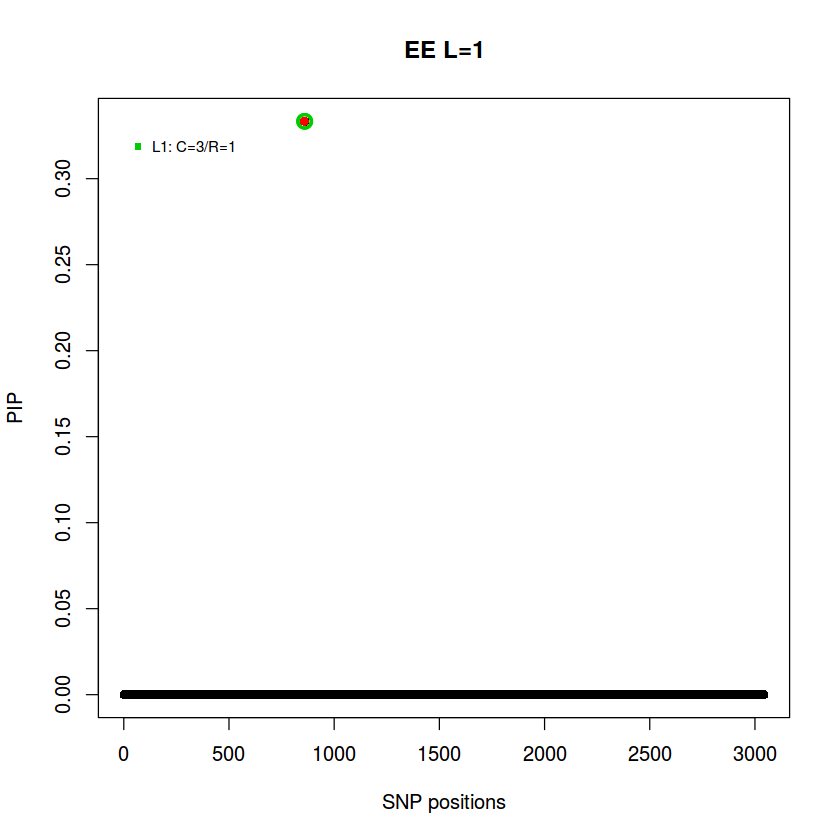

In [6]:
susieR::susie_plot(r1, y='PIP', main = 'EE L=1', xlab = 'SNP positions', add_legend = T, b=true_pos)

So with $L=1$ the first SNP was captured but with low PIP. This is apparently also the top BF. Now try `L=2` to verify the problem:

In [7]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r1 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)

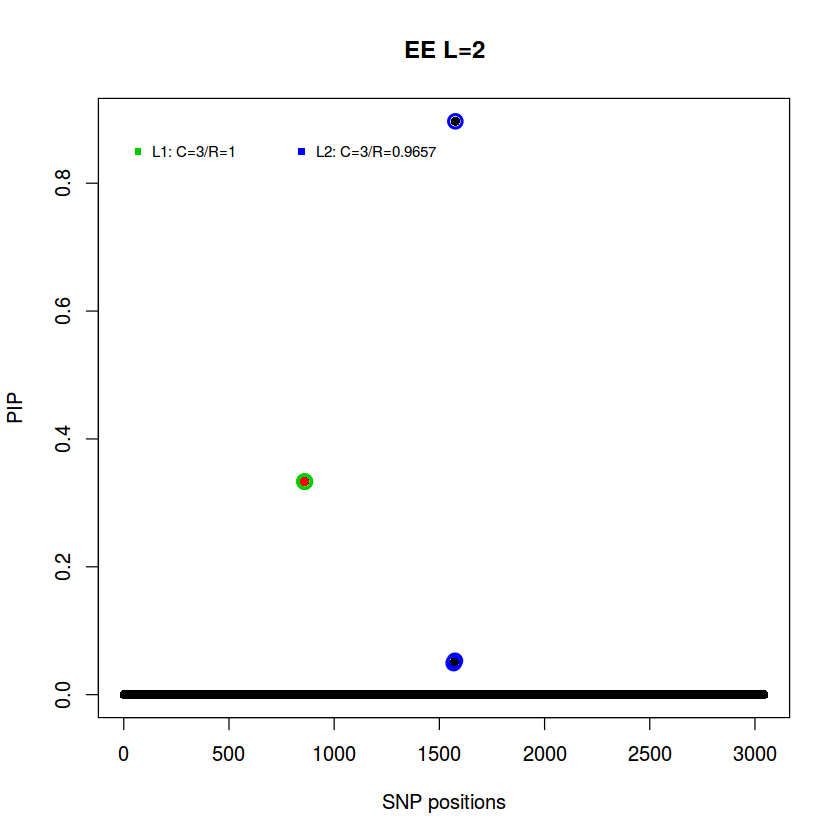

In [8]:
susieR::susie_plot(r1, y='PIP', main = 'EE L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Diagnosis using Bayesian multiple regression prior

Here the MASH prior is very simple:

In [9]:
str(m_init$prior_variance)

List of 2
 $ pi    : num [1:2] 0 1
 $ xUlist:List of 2
  ..$ : num [1:45, 1:45] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ : num [1:45, 1:45] 0.09 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 0.0225 ...


So prior variance is one matrix,

In [10]:
U = m_init$prior_variance$xUlist[[2]]
dim(U)

[1] 45 45

Now fitting it with multivariate Bayesian regression routine not involving MASH. The result should be identical to using MASH EE model in this case:

In [11]:
r2 = mmbr::msusie(X, Y, L=2, prior_variance=U, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F)

It converged reasonably fast. The result remains the same:

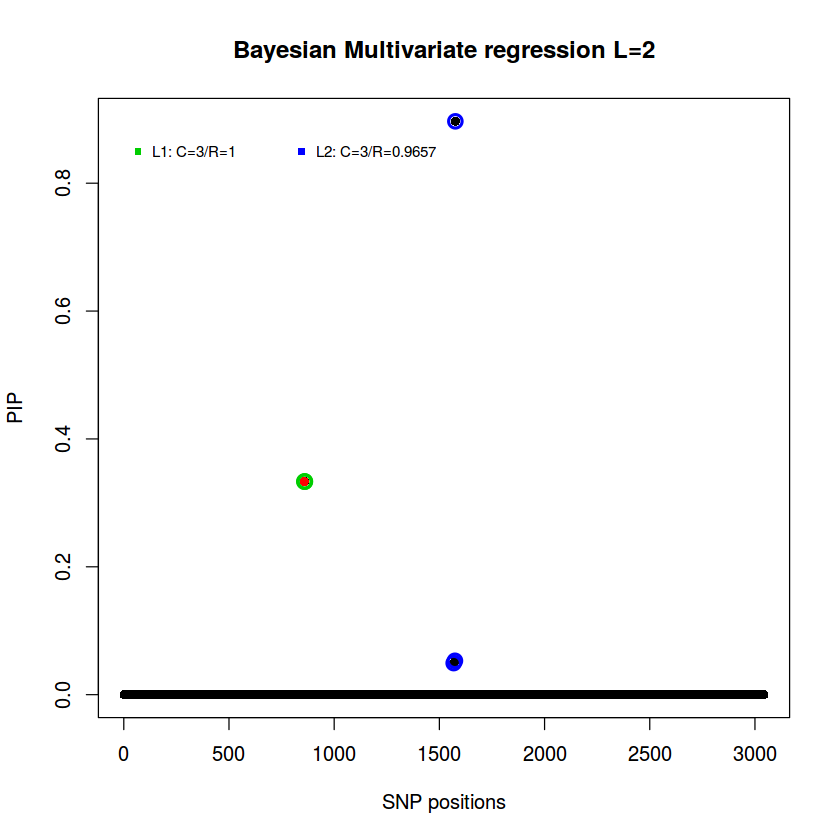

In [12]:
susieR::susie_plot(r2, y='PIP', main = 'Bayesian Multivariate regression L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Current EE model behavior

In [13]:
m_init$precompute_cov_matrices(mmbr:::DenseData$new(X,Y),resid_Y)

In [14]:
m_init$precomputed$common_sbhat

[1] TRUE

For data without center and scale,

In [15]:
m_init$precompute_cov_matrices(mmbr:::DenseData$new(X,Y,center=F,scale=F),resid_Y)
m_init$precomputed$common_sbhat

[1] FALSE

And not scaling does change result a bit though not completely, see below (why??):

In [16]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r3 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, standardize=F)

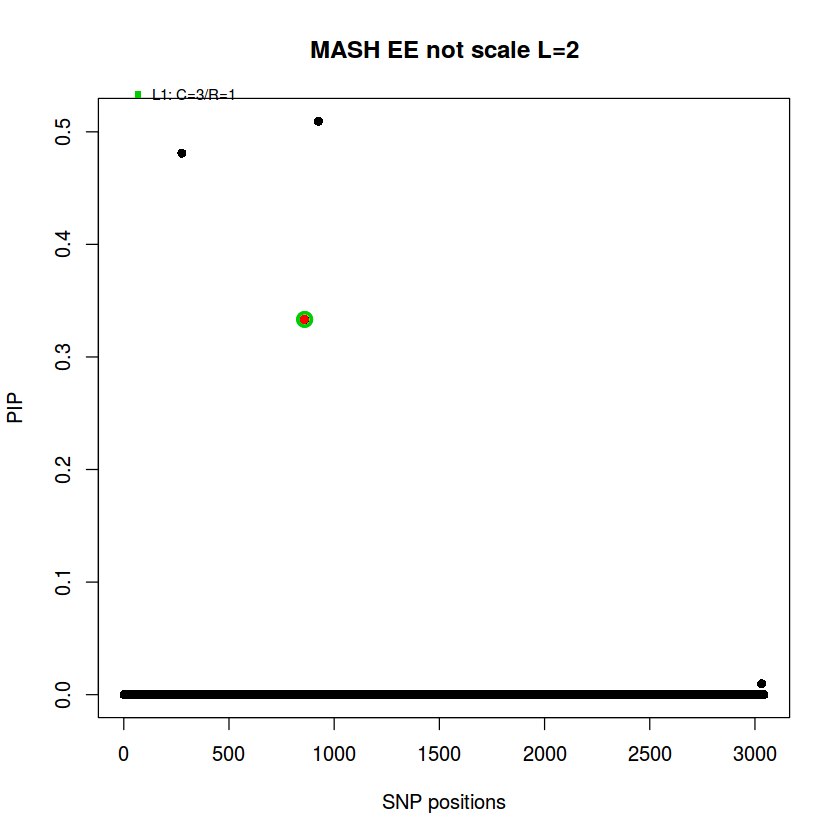

In [17]:
susieR::susie_plot(r3, y='PIP', main = 'MASH EE not scale L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

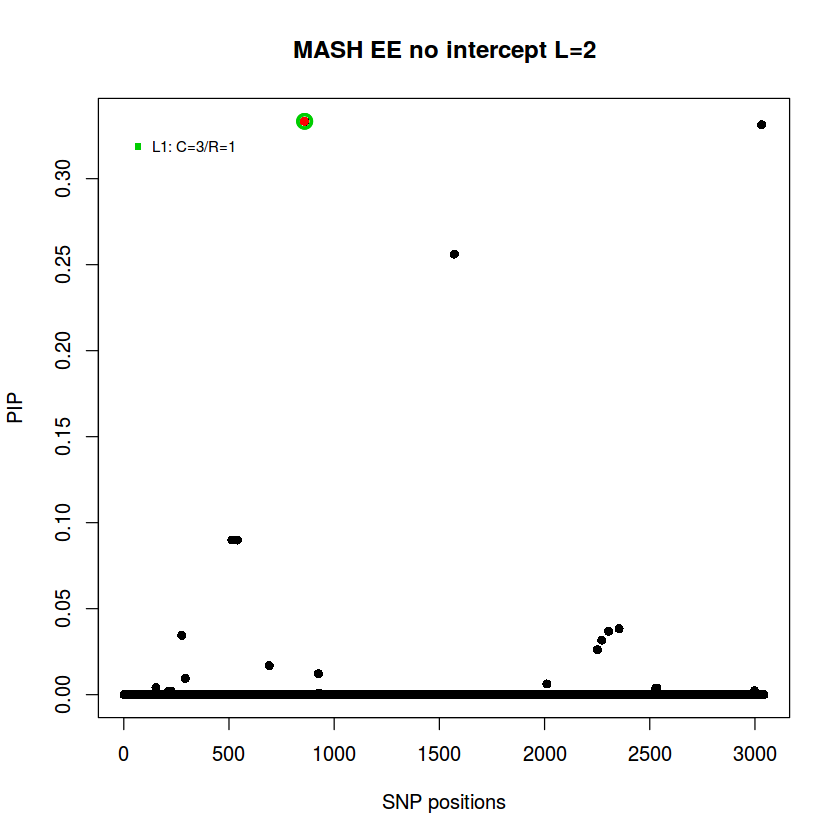

In [18]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r3 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, intercept=F)
susieR::susie_plot(r3, y='PIP', main = 'MASH EE no intercept L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

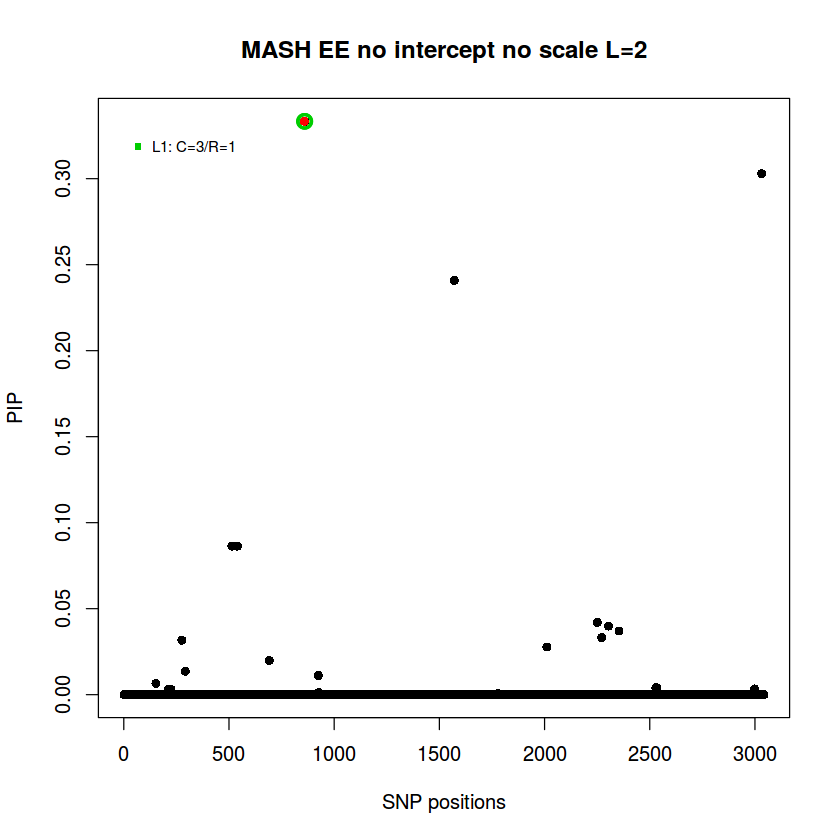

In [19]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
r3 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, intercept=F, standardize=F)
susieR::susie_plot(r3, y='PIP', main = 'MASH EE no intercept no scale L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

Using EZ model, however, gives a bit better result:

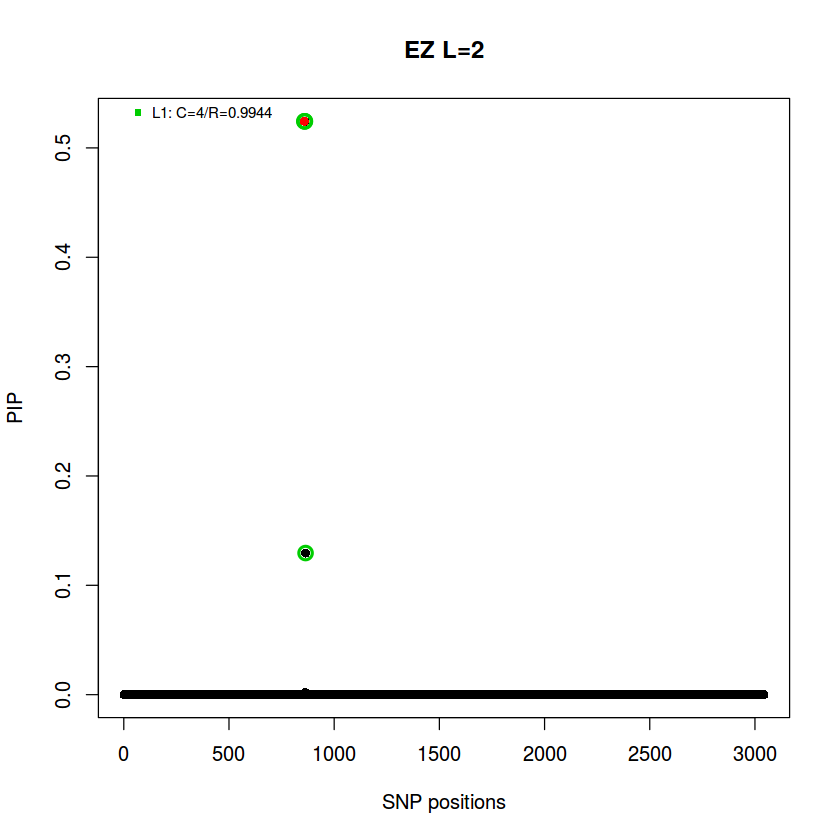

In [20]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=1, top_mixtures=-1)
r4 = mmbr::msusie(X, Y, L=2, prior_variance=m_init, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=F, precompute_covariance = F)
susieR::susie_plot(r4, y='PIP', main = 'EZ L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

## A deeper look into the problem

Now compare result of one run with `BayesianMultivariateRegression` vs `MashRegression`:

In [21]:
data = mmbr:::DenseData$new(X,Y)

In [22]:
A = mmbr:::BayesianMultivariateRegression$new(ncol(X), resid_Y, prior$xUlist[[1]])
A$fit(data,save_summary_stats=T)

In [23]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=0, top_mixtures=-1)
B = mmbr:::MashRegression$new(ncol(X), resid_Y, m_init)
B$fit(data, save_summary_stats = T)

In [25]:
testthat::expect_equal(A$bhat,B$bhat)

In [26]:
testthat::expect_equal(A$sbhat, B$sbhat)

In [27]:
testthat::expect_equal(A$posterior_b1, B$posterior_b1)

In [28]:
testthat::expect_equal(as.vector(A$posterior_b2), as.vector(B$posterior_b2))

In [29]:
testthat::expect_equal(A$lbf, B$lbf)

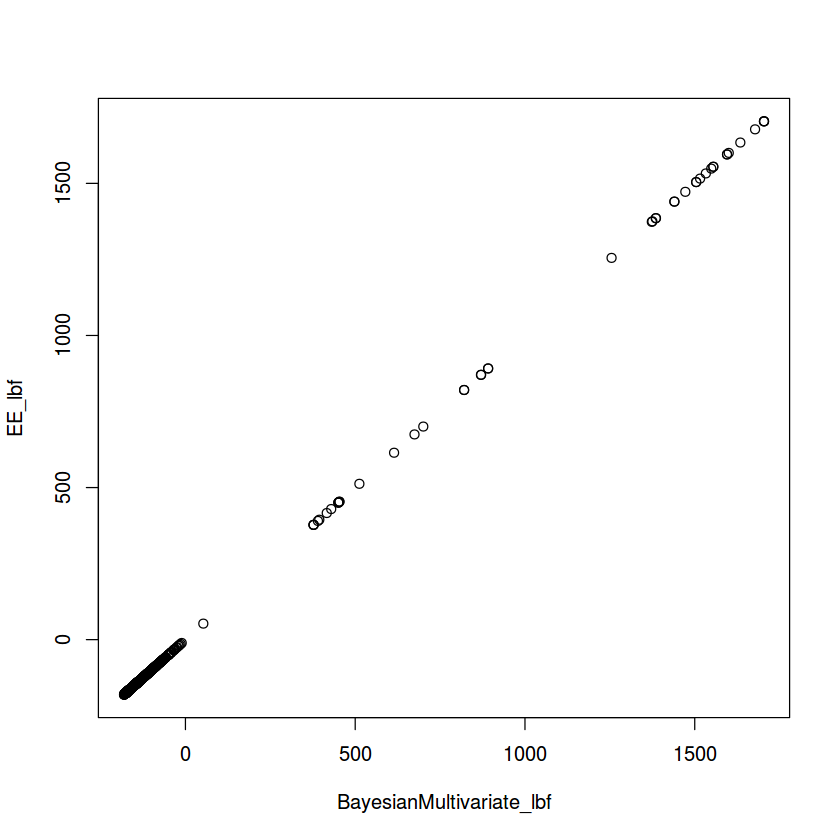

In [30]:
plot(A$lbf, B$lbf,xlab='BayesianMultivariate_lbf', ylab='EE_lbf')

All seems fine and some lbf are very big. But there is nothing unusual about them.

In [31]:
head(B$bhat[which(B$lbf>800),])

chr6_143035644_C_T_b38,0.03191711,-0.01393717,0.01818342,0.05300816,0.01281199,-0.1107298,-0.008728405,-0.08866899,-0.03680164,0.06927545,⋯,-0.04933008,0.01471045,0.05569323,-0.02643182,-0.05296921,0.06410971,-0.06249192,-0.01311766,-0.06495953,-0.1192991
chr6_143037783_G_A_b38,0.03191711,-0.01393717,0.01818342,0.05300816,0.01281199,-0.1107298,-0.008728405,-0.08866899,-0.03680164,0.06927545,⋯,-0.04933008,0.01471045,0.05569323,-0.02643182,-0.05296921,0.06410971,-0.06249192,-0.01311766,-0.06495953,-0.1192991
chr6_143054989_T_C_b38,0.03317224,-0.01402643,0.01866062,0.05213740,0.01307362,-0.1130610,-0.008979551,-0.10395232,-0.03676040,0.07759277,⋯,-0.05537357,0.01600376,0.05883313,-0.02556160,-0.05445864,0.06870743,-0.06312323,-0.01357630,-0.06356515,-0.1234546
chr6_143061397_C_CAACT_b38,0.03283454,-0.01485454,0.01900058,0.05350558,0.01269271,-0.1196935,-0.008871870,-0.09018506,-0.03673872,0.07639759,⋯,-0.05656059,0.01568886,0.05661240,-0.02599053,-0.05414823,0.06695872,-0.06566089,-0.01289136,-0.06524088,-0.1200244
chr6_143065478_T_TTCATTCAC_b38,0.03217323,-0.01570857,0.01897424,0.05431236,0.01252902,-0.1176026,-0.008838594,-0.08843620,-0.03831390,0.07422039,⋯,-0.05818561,0.01642406,0.05710954,-0.02761353,-0.05636623,0.06914413,-0.06410975,-0.01271867,-0.06563208,-0.1200385
chr6_143066202_T_C_b38,0.03217323,-0.01570857,0.01897424,0.05431236,0.01252902,-0.1176026,-0.008838594,-0.08843620,-0.03831390,0.07422039,⋯,-0.05818561,0.01642406,0.05710954,-0.02761353,-0.05636623,0.06914413,-0.06410975,-0.01271867,-0.06563208,-0.1200385


In [118]:
head(B$sbhat[which(B$lbf>800),])

0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204
0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204
0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204
0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204
0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204
0.005363237,0.002271185,0.002623408,0.008212505,0.001768074,0.01955708,0.001190877,0.01959203,0.005542169,0.01071347,⋯,0.008173358,0.002769517,0.006856114,0.003994697,0.007551705,0.009740986,0.008874155,0.001648668,0.01069181,0.01517204


Using EZ I get this,

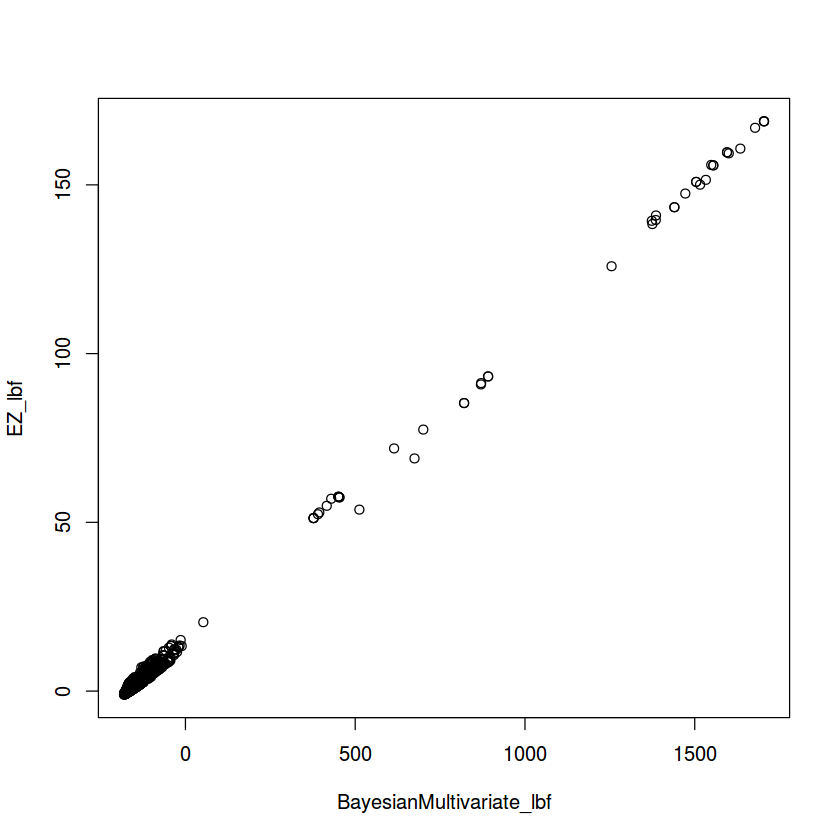

In [34]:
m_init = mmbr:::MashInitializer$new(NULL, NULL, xUlist=prior$xUlist, prior_weights=prior$pi, null_weight=prior$null_weight, alpha=1, top_mixtures=-1)
B = mmbr:::MashRegression$new(ncol(X), resid_Y, m_init)
B$fit(data, save_summary_stats = T)
plot(A$lbf, B$lbf,xlab='BayesianMultivariate_lbf', ylab='EZ_lbf')

The trends are the same but only lbf scale is smaller.

## Impact of model mis-specification

What if the results are correct after all, but driven by mis-specified prior? Because `L=2` is wrong. So here I estimate prior variance for `BayesianMultivariateRegression`,

In [35]:
r2 = mmbr::msusie(X, Y, L=2, prior_variance=U, residual_variance=resid_Y, compute_objective=F, estimate_residual_variance=F, estimate_prior_variance=T, estimate_prior_method='simple')

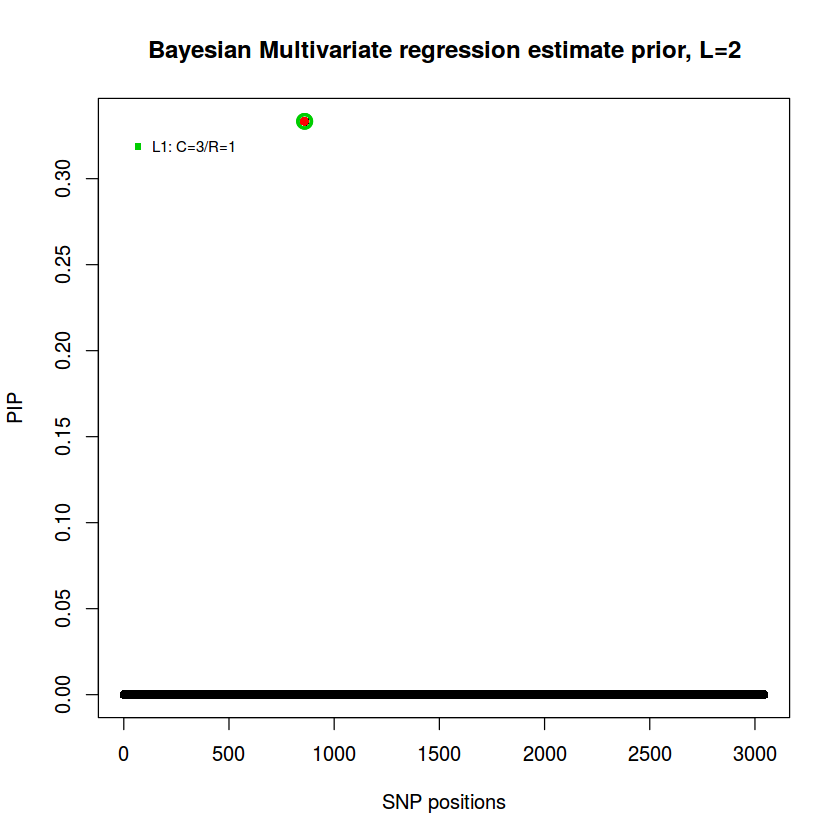

In [36]:
susieR::susie_plot(r2, y='PIP', main = 'Bayesian Multivariate regression estimate prior, L=2', xlab = 'SNP positions', add_legend = T, b=true_pos)

Now it seems to work! So this is a problem with model mis-specification.